In [2]:
# importing libraries and packages to perform this text analysis
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
# Check tensorflow version 
print(tf.version.VERSION)
print(tf.__version__)

2.4.1
2.4.1


In [4]:
# Download IMDB dataset on disk and explore the dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file( "aclImdb_v1.tar.gz", url, untar = True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84131840/84125825 [==============================] - 5s 0us/step


In [5]:
# Check what I have in the IMDB dataset directory
print(os.listdir(dataset_dir))
os.listdir(dataset_dir)

['test', 'imdbEr.txt', 'README', 'imdb.vocab', 'train']


['test', 'imdbEr.txt', 'README', 'imdb.vocab', 'train']

In [6]:
# Set this directory as the training dataset directory and check the file list in this directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'unsup',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt',
 'urls_pos.txt',
 'pos']

In [7]:
# Take a look at a text file from the directory. Read the text from the file and print this  
sample_file = os.path.join(train_dir,'pos/0_9.txt')
#file = open(sample_file).read()
#file = open(sample_file).readline()
#print(file)
with open(sample_file) as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [8]:
# Remove unnecessary file from the directory
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
# Running machine learning experiment to the labeled data and check if I have three types of dataset (train, validation, and test)
# Here, I am creating training dataset for the model
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory( 'aclImdb/train', batch_size = batch_size, validation_split = 0.2, subset ='training', seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
# Print example to view label of the data. I get 0 and 1 as label of data.
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review",text_batch.numpy()[i])
    print("Label",label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
# Print what these labels means?
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 0 corresponds to pos


In [12]:
# Creat validation dataset
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size= batch_size, validation_split=0.2,subset='validation',seed=seed) 

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [34]:
# Create test dataset
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [14]:
# Print the class of these three dataset
print(raw_test_ds.class_names)
print(raw_val_ds.class_names)
print(raw_train_ds.class_names)

['neg', 'pos']
['neg', 'pos']
['neg', 'pos']


In [15]:
# Prepare the dataset
# Create a user defined function to remove HTML tag '<br />' for the dataset
def custom_standerdization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),'')

In [16]:
# Create a TextVectorization layer to standardize, tokenize and vectorize my dataset
max_features = 10000  # maximun size of the vocabulary for this task
sequence_length = 250 # pad limit

vectorize_layer = TextVectorization( standardize=custom_standerdization, max_tokens= max_features, output_mode='int',output_sequence_length=sequence_length)

In [17]:
# Make a text only dataset without labels 
train_text = raw_train_ds.map(lambda x, y:x) # (x,y) means (Review,label)
#print(train_text)
# Call the adapt() function fit the state of the preprocessing layer to the dataset. This will build an index of strings to integers
vectorize_layer.adapt(train_text)

In [18]:
# Create a user defined function see the result of preprocessing stage (i.e a list of integers converted from string data)
def vectorize_text(text,label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text) , label

In [19]:
# Print the converted intergers from the string data
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review,first_label))


Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [20]:
# Check and print what integer represents which string/word.
print("10:", vectorize_layer.get_vocabulary()[10])
print("344:", vectorize_layer.get_vocabulary()[344])
print("5188:", vectorize_layer.get_vocabulary()[5188])
print("6:", vectorize_layer.get_vocabulary()[6])
print("0:", vectorize_layer.get_vocabulary()[0])
print("Vocabulary size: ", len(vectorize_layer.get_vocabulary()))

10: i
344: try
5188: objective
6: to
0: 
Vocabulary size:  10000


In [21]:
# Apply TextVectorization layer to the train, validation and test dataset before fed into the model
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
# Configure dataset for performance by using cache() and prefetch()
AUTOTUNE = tf.data.AUTOTUNE
# The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.
# Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time.
# The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [23]:
# Create the Neural Network (model)
embedding_dim = 16
# input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
# output_dim: Integer. Dimension of the dense embedding

In [24]:
# Define and set the layer of this Neural Network. I am setting four layer for this NN. The detail is on my report.
model = tf.keras.Sequential( [ 
                              layers.Embedding(max_features+1, embedding_dim),
                              layers.Dropout(0.2),
                              layers.GlobalAveragePooling1D(),
                              layers.Dropout(0.2),
                              layers.Dense(1)] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Configure the model to use a loss function and an optimizer
model.compile(loss=losses.BinaryCrossentropy(from_logits= True), optimizer='adam',metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [26]:
# Train this NN model
epochs = 10
#Each trail to learn from the input dataset is called an epoch
history = model.fit( train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6827 - binary_accuracy: 0.6093 - val_loss: 0.6146 - val_binary_accuracy: 0.7710
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5796 - binary_accuracy: 0.7829 - val_loss: 0.4978 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4652 - binary_accuracy: 0.8345 - val_loss: 0.4197 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3902 - binary_accuracy: 0.8592 - val_loss: 0.3736 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3440 - binary_accuracy: 0.8741 - val_loss: 0.3447 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3101 - binary_accuracy: 0.8873 - val_loss: 0.3259 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [27]:
# Check loss and accuracy to evaluate the performance of this model
# Gradient Descent is an optimization algorithm for finding a local minimum of a differentiable function. Gradient descent is simply used to find the values of a function's parameters (coefficients) that minimize a cost function as far as possible.
loss, accuracy = model.evaluate(test_ds)

print("Loss",loss)
print("Accuracy",accuracy)

782/782 [==============================] - 9s 12ms/step - loss: 0.3102 - binary_accuracy: 0.8735
Loss 0.3101915419101715
Accuracy 0.873520016670227


In [28]:
# create a plot to better understand
# model.fit() returns a History object that contains a dictionary with everything that happened during training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

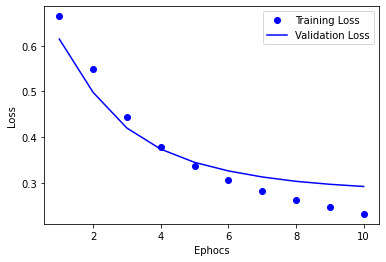

In [29]:
# plot to visualize loss
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)
# "bo" for blue dot
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
# "b" for solid bule line
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.xlabel("Ephocs")
plt.ylabel("Loss")
plt.legend()
plt.show()

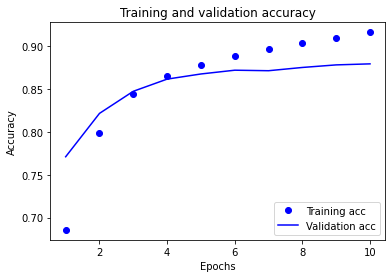

In [30]:
# plot to visualize accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [31]:
# In the code above, I applied the TextVectorization layer to the dataset before feeding text to the model. If I want to make my model capable of processing raw strings (for example, to simplify deploying it), I can include the TextVectorization layer inside the model. 
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3043 - accuracy: 0.8766
0.873520016670227


In [33]:
# To get predictions for new examples, I simply call model.predict()
new_examples = ["Exciting movie. Super!", "I don't like the ending scence. Bad story.", "I was expecting more.", "Excellent movie", "I like this horror movie!", "I am sorry to say but Idont like this movie."]

# Print vectors for new example
export_model.predict(new_examples)

array([[0.5624368 ],
       [0.36314815],
       [0.58180296],
       [0.67614913],
       [0.5000946 ],
       [0.38121626]], dtype=float32)